In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import defaultdict

In [6]:
agents_df = pd.read_csv("agent_results.csv")
model_df = pd.read_csv("model_results.csv", index_col=0)

# Convert Position string to tuple or int
def parse_position(pos):
    try:
        return ast.literal_eval(pos)
    except:
        return pos

agents_df["Position"] = agents_df["Position"].apply(parse_position)

In [7]:
vehicle_summary = []

for agent_id, group in agents_df.groupby("AgentID"):
    speeds = group["Speed"]
    positions = group["Position"]
    
    avg_speed = speeds.mean()
    zero_speed_steps = (speeds == 0).sum()
    road_positions = [p for p in positions if isinstance(p, tuple)]
    unique_roads = set(road_positions)
    
    summary = {
        "AgentID": agent_id,
        "VehicleType": group["VehicleType"].iloc[0],
        "Steps": len(group),
        "StepsStopped": zero_speed_steps,
        "PercentStopped": zero_speed_steps / len(group),
        "AvgSpeed": avg_speed,
        "RoadCount": len(unique_roads),
    }
    vehicle_summary.append(summary)

vehicle_summary_df = pd.DataFrame(vehicle_summary)
vehicle_summary_df.head()

,AgentID,VehicleType,Steps,StepsStopped,PercentStopped,AvgSpeed,RoadCount
0,1,Car,47,1,0.021277,18.382979,4
1,2,Bus,52,5,0.096154,14.884615,4
2,3,Motorcycle,31,1,0.032258,12.077419,4
3,4,Bus,98,6,0.061224,14.289796,7
4,5,Motorcycle,50,1,0.020000,17.496000,4


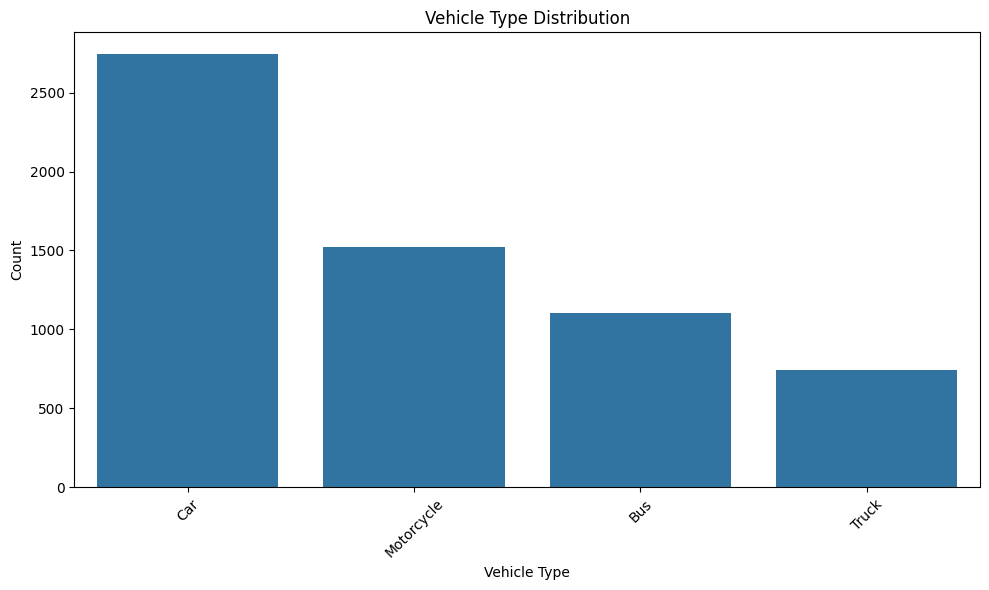

In [25]:
# check the vehicle distribution
vehicle_counts = vehicle_summary_df["VehicleType"].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=vehicle_counts.index, y=vehicle_counts.values)
plt.title("Vehicle Type Distribution")
plt.xlabel("Vehicle Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()



In [8]:
# Count how many times each road was used and collect speeds per road
road_data = defaultdict(lambda: {"count": 0, "speeds": []})

for _, row in agents_df.iterrows():
    pos = row["Position"]
    if isinstance(pos, tuple):
        road_data[pos]["count"] += 1
        road_data[pos]["speeds"].append(row["Speed"])

# Convert to DataFrame
road_stats = []

for road, data in road_data.items():
    road_stats.append({
        "Road": road,
        "UsageCount": data["count"],
        "AvgSpeed": np.mean(data["speeds"]),
        "MaxSpeed": np.max(data["speeds"]),
        "MinSpeed": np.min(data["speeds"]),
        "MedianSpeed": np.median(data["speeds"]),
    })

road_df = pd.DataFrame(road_stats)
road_df.set_index("Road", inplace=True)
road_df.sort_values("UsageCount", ascending=False).head()

,UsageCount,AvgSpeed,MaxSpeed,MinSpeed,MedianSpeed
Road,,,,,
"(236160072, 236160006)",46292,19.557677,25.2,0.0,21.6
"(236160006, 236160072)",33672,19.880506,25.2,0.0,25.2
"(281474610, 281474691)",21579,14.833922,25.2,0.0,14.4
"(495649040, 273461469)",18779,15.344331,25.2,0.0,18.0
"(236160006, 236306981)",16797,12.532595,25.2,0.0,14.4


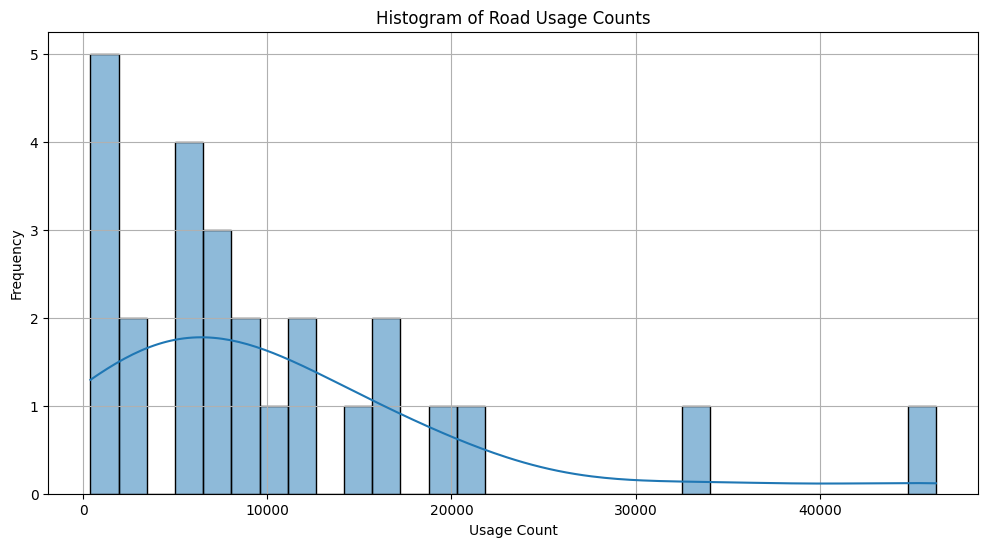

In [9]:
# Map road tuples to x/y grid for visualization
road_index = {road: i for i, road in enumerate(road_df.index)}

heat_data = pd.DataFrame(index=road_index.keys())
heat_data["UsageCount"] = road_df["UsageCount"]

plt.figure(figsize=(12, 6))
sns.histplot(road_df["UsageCount"], bins=30, kde=True)
plt.title("Histogram of Road Usage Counts")
plt.xlabel("Usage Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

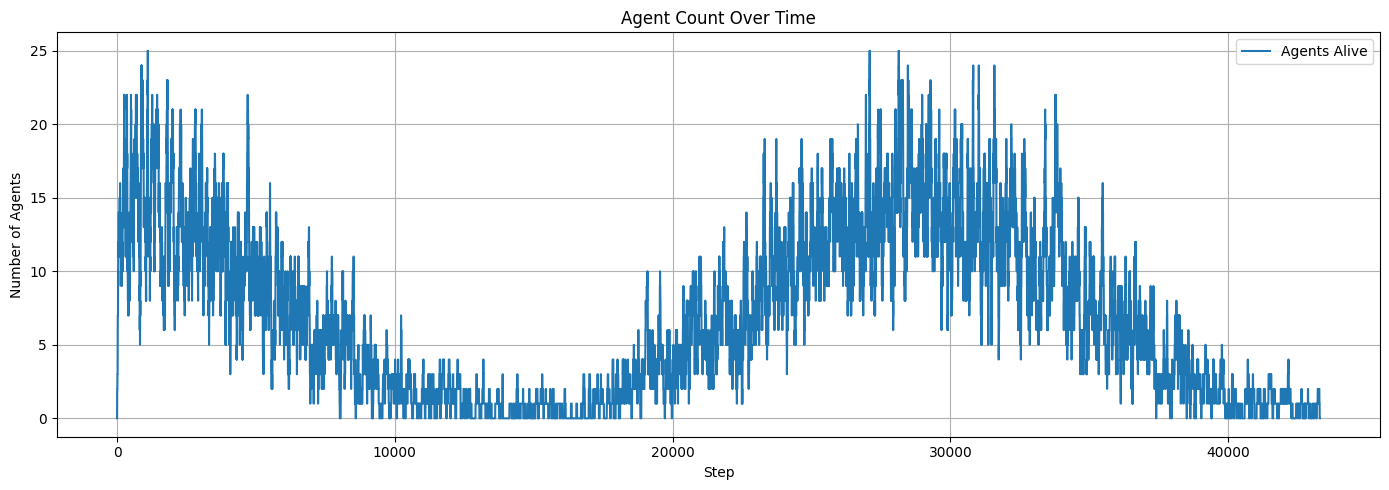

In [10]:
plt.figure(figsize=(14, 5))
plt.plot(model_df.index, model_df["AgentCount"], label="Agents Alive")
plt.xlabel("Step")
plt.ylabel("Number of Agents")
plt.title("Agent Count Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

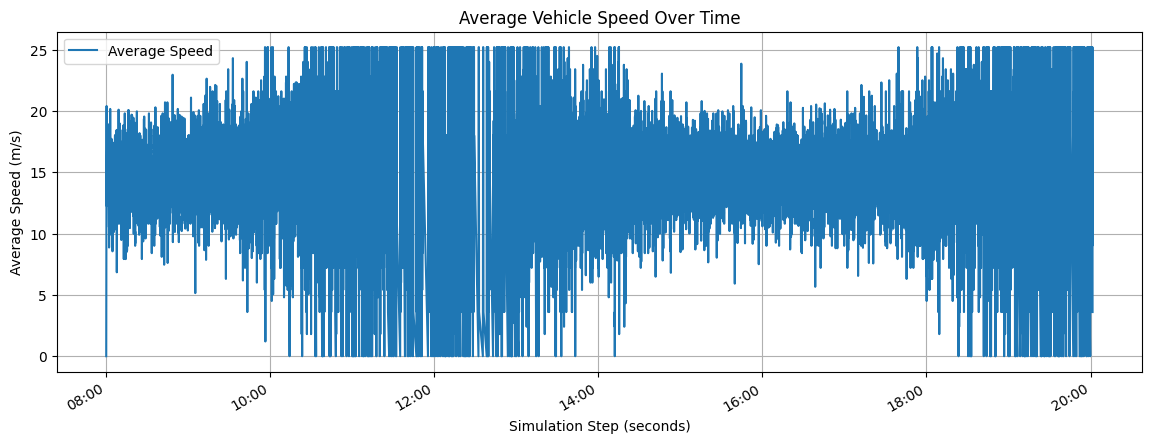

In [23]:
from datetime import datetime, timedelta

avg_speed_per_step = agents_df.groupby("Step")["Speed"].mean()

plt.figure(figsize=(14, 5))
import matplotlib.dates as mdates

# Convert step index (seconds since 8:00:00) to datetime objects
start_time = datetime.strptime("08:00:00", "%H:%M:%S")
time_labels = [start_time + timedelta(seconds=int(s)) for s in avg_speed_per_step.index]

plt.plot(time_labels, avg_speed_per_step.values, label="Average Speed")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate()
plt.xlabel("Simulation Step (seconds)")
plt.ylabel("Average Speed (m/s)")
plt.title("Average Vehicle Speed Over Time")
plt.grid(True)
plt.legend()
plt.show()

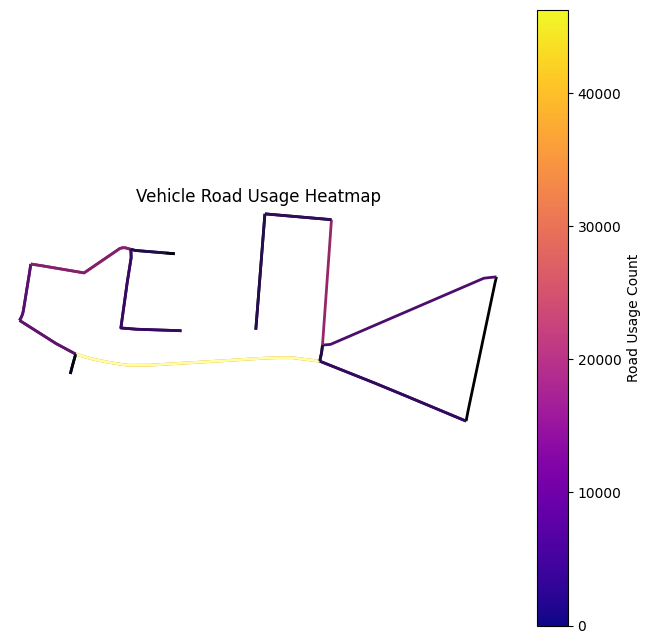

In [30]:
import osmnx as ox
import networkx as nx

# Load graph
G = ox.graph.graph_from_bbox((19.912119, 50.066637, 19.921871, 50.069047), network_type='drive')

# Assign edge usage count as edge attribute
usage_dict = {road: count for road, count in zip(road_df.index, road_df["UsageCount"])}

for u, v, k, data in G.edges(keys=True, data=True):
    edge_key = (u, v)
    usage = usage_dict.get(edge_key, 0)
    data["usage"] = usage

# Normalize and color edges
max_usage = max(usage_dict.values()) if usage_dict else 1
ec = [G[u][v][k].get("usage", 0) for u, v, k in G.edges(keys=True)]

# Plot
# Map usage counts to colors using a colormap
cmap = plt.cm.inferno
norm = plt.Normalize(vmin=0, vmax=max_usage)
edge_colors = [cmap(norm(val)) for val in ec]

fig, ax = ox.plot_graph(
  G,
  edge_color=edge_colors,
  edge_linewidth=2,
  bgcolor='white',
  node_size=0,
  show=False,
  close=False
)

sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=max_usage))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Road Usage Count")

plt.title("Vehicle Road Usage Heatmap")
plt.show()
